In [1]:
from mesh_to_sdf import mesh_to_voxels, sample_sdf_near_surface, scale_to_unit_cube

import trimesh
import skimage
import sklearn
import numpy as np
import pyrender
import matplotlib.pyplot as plt
import mesh_to_sdf


In [75]:
mesh = trimesh.load('data/rect.obj')
mesh = scale_to_unit_cube(mesh)

In [76]:
res = 512
size_range = 4.0

size_range_x = size_range
size_range_y = size_range

In [77]:
lattice_x = size_range_x / (res - 1)
lattice_y = size_range_y / (res - 1)
ha_x = size_range_x / 2 + lattice_x
ha_y = size_range_y / 2 + lattice_y
# create an uniform array of query points between -2 and +2
query_points_x = np.linspace(-ha_x, ha_x, res+2)
query_points_y = np.linspace(-ha_y, ha_y, res+2)

query_points = np.meshgrid(query_points_x, query_points_y)

# stack into 3d points and append 0 for z dimension
query_points = np.stack(query_points, axis=2)
query_points = np.append(query_points, np.zeros_like(query_points[:, :, :1]), axis=2)

# reshape to a list of 3d coordinates
query_points = query_points.reshape(-1, 3)


In [78]:
voxel = mesh_to_sdf.mesh_to_sdf(mesh, query_points, surface_point_method='scan', sign_method='depth', bounding_radius=None,
                                scan_count=100, scan_resolution=400, sample_point_count=10000000, normal_sample_count=11)

# reshape to image
voxel = voxel.reshape(res+2, res+2)

In [79]:
voxel.shape

(514, 514)

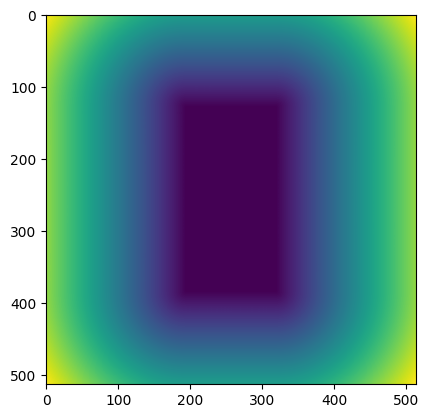

In [80]:
plt.imshow(np.flip(voxel, axis=0))

In [81]:
voxel_xy = voxel.transpose()
grad = np.gradient(voxel_xy)

In [82]:
# grad = np.zeros([res,res,2])
# for x in range(0,res):
#     for y in range(0,res):
#         grad[x,y,0] = (voxel[x+2,y] - voxel[x,y]) / (2*lattice_x)
#         grad[x,y,1] = (voxel[x,y+2] - voxel[x,y]) / (2*lattice_y)


In [83]:
grad_arr = np.stack(grad, axis=-1)

# Now, remove the outer boundary. The result will be of shape nxnx2.
grad_arr = grad_arr[1:-1, 1:-1]

In [84]:
# grad_arr[0:3, 0:3, :]

In [85]:
# grad_arr = grad

In [86]:
# Compute the magnitude of the gradient
grad_mag = np.sqrt(np.sum(grad_arr**2, axis=-1))

# Normalize the gradient by dividing by the magnitude
norm_grad = grad_arr / grad_mag[..., None]

# Replace any NaNs that might have resulted from division by zero
norm_grad = np.nan_to_num(norm_grad)

In [87]:
norm_grad.shape

(512, 512, 2)

In [88]:
position_map = np.zeros([res,res,2])

In [89]:
# position_map.shape
for x in range(0, res):
    for y in range(0,res):
        ref_x = - size_range_x / 2 + x * lattice_x
        ref_y = - size_range_y / 2 + y * lattice_y
        point_to_x = ref_x - norm_grad[x,y,0] * voxel_xy[x+1,y+1]
        point_to_y = ref_y - norm_grad[x,y,1] * voxel_xy[x+1,y+1]
        position_map[x,y,0] = point_to_x
        position_map[x,y,1] = point_to_y

In [71]:
# position_map

In [72]:
# plt.imshow(position_map[:,:,0])
# 

In [73]:
# plt.imshow(position_map[:,:,1])

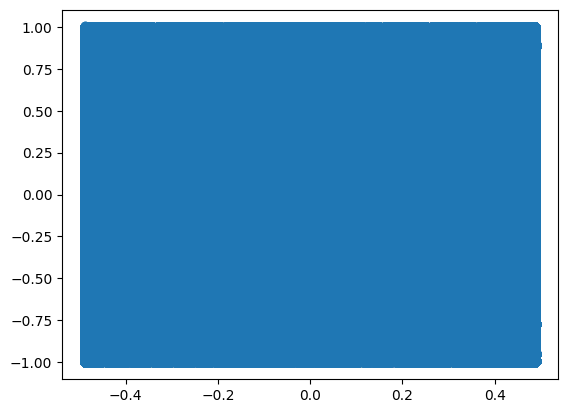

In [90]:
x_coords = position_map[:,:,0].flatten()
y_coords = position_map[:,:,1].flatten()

plt.scatter(x_coords, y_coords)
plt.show()

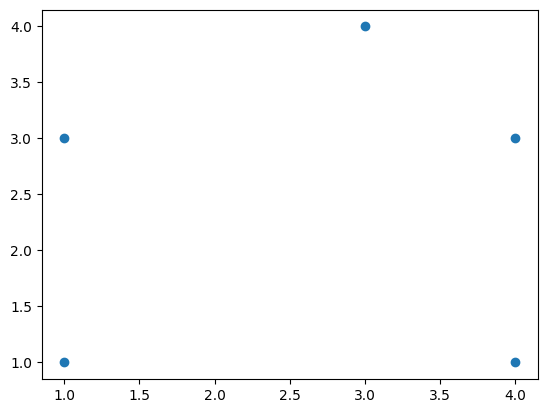

In [31]:
plt.scatter([1,4,4,3,1],[1,1,3,4,3] )
plt.show()